
🔬 PREDICTING ON TEST SET
Found 8479 images belonging to 2 classes.
Classes: ['fake', 'real']
Original Validation Set Size: 8479
New Test Set Size: 4240 samples


Loading New Test Images: 100%|██████████| 4240/4240 [00:18<00:00, 234.59it/s]


Processed Test Data Shape: (4240, 224, 224, 3)


530/530 ━━━━━━━━━━━━━━━━━━━━ 167s 308ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

        fake       0.80      0.97      0.88      2765
        real       0.90      0.54      0.68      1475

    accuracy                           0.82      4240
   macro avg       0.85      0.75      0.78      4240
weighted avg       0.83      0.82      0.81      4240


===== FINAL TEST RESULTS =====
Model Used: Resnet50V2_unfrozen
Accuracy:   0.8198
Precision:  0.9017
Recall:     0.5410
F1-score:   0.6763
AUC-ROC:    0.9264


📊 GENERATING CONFUSION MATRIX
✅ Saved Confusion Matrix plot: figures/confusion_matrix_test_set.png


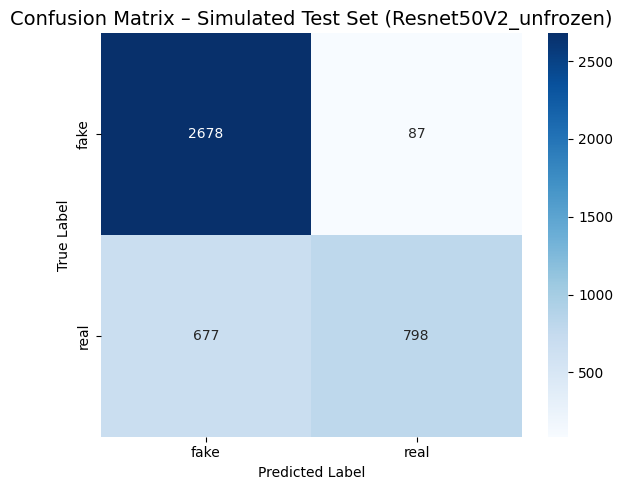


🎉 TEST SET EVALUATION COMPLETE!


In [2]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

print(f"\n{'='*70}")
print("🔬 PREDICTING ON TEST SET")
print(f"{'='*70}")

# Import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import random
random.seed(42)

ROOT = Path("Datasets/Datasets")

IMG_SIZE = (224, 224)
BATCH_SIZE = 8

datagen = ImageDataGenerator(rescale=1./255)

val_gen = datagen.flow_from_directory(
    directory=ROOT / "valid",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
    classes=['fake', 'real']
)

val_filepaths = [ROOT / "valid" / f for f in val_gen.filenames]
val_labels = val_gen.classes # This is an array of 0s and 1s (0 for 'fake', 1 for 'real')
class_names = list(val_gen.class_indices.keys())
print(f"Classes: {class_names}")

indices = list(range(len(val_filepaths)))
random.shuffle(indices)

half_split_index = len(indices) // 2
new_val_indices = indices[:half_split_index]
new_test_indices = indices[half_split_index:]

print(f"Original Validation Set Size: {len(val_filepaths)}")
print(f"New Test Set Size: {len(new_test_indices)} samples")


new_test_filepaths = [val_filepaths[i] for i in new_test_indices]
new_test_labels = np.array([val_labels[i] for i in new_test_indices])


new_test_images = []
for file_path in tqdm(new_test_filepaths, desc="Loading New Test Images"):
    img = cv2.imread(str(file_path))
    if img is None:
        print(f"Warning: Could not load image {file_path}. Skipping.")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    # Apply rescaling (1./255) as done by the ImageDataGenerator
    img = img / 255.0 
    new_test_images.append(img)

new_test_data = np.array(new_test_images)
print(f"Processed Test Data Shape: {new_test_data.shape}")


best_model = load_model('models/resnet50v2_unfrozen_model.h5')
best_model_name = 'Resnet50V2_unfrozen'

test_probs = best_model.predict(
    new_test_data,
    batch_size=BATCH_SIZE,
    verbose=1
)


test_preds = (test_probs > 0.5).astype(int).flatten()

# --- (6) Compute Metrics ---
accuracy = accuracy_score(new_test_labels, test_preds)
precision = precision_score(new_test_labels, test_preds, average='binary')
recall = recall_score(new_test_labels, test_preds, average='binary')
f1 = f1_score(new_test_labels, test_preds, average='binary')
auc_score = roc_auc_score(new_test_labels, test_probs)

print("\nClassification Report on Test Set:")
print(classification_report(new_test_labels, test_preds, target_names=class_names))

# --- (7) Print Summary ---
print("\n===== FINAL TEST RESULTS =====")
print(f"Model Used: {best_model_name}")
print(f"Accuracy:   {accuracy:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-score:   {f1:.4f}")
print(f"AUC-ROC:    {auc_score:.4f}")
print("================================================\n")


# --- (8) Confusion Matrix Plot ---
print(f"\n{'='*30}")
print("📊 GENERATING CONFUSION MATRIX")
print(f"{'='*30}")

cm = confusion_matrix(new_test_labels, test_preds)
import seaborn as sns # Import here just in case it wasn't available globally
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    cmap='Blues',
    fmt='d', # 'd' for integer format
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title(f"Confusion Matrix – Simulated Test Set ({best_model_name})", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
cm_plot_path =  "figures/confusion_matrix_test_set.png"
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved Confusion Matrix plot: {cm_plot_path}")
plt.show()

print("\n" + "="*70)
print("🎉 TEST SET EVALUATION COMPLETE!")
print("="*70)